Spark Session web UI: http://10.50.221.198:4040
Cluster ID 0
Most common tags: 
	country
	my favorite
	great song
	modern country
	male vocalists
Cluster ID 1
Most common tags: 
	pop
	favorites
	rock
	love
	male vocalists
Could not get tags for Song ID <unk>
Cluster ID 2
Most common tags: 
	rock
	pop
	favorites
	#
	male vocalists
Cluster ID 3
Most common tags: 
	rock
	favorites
	pop
	male vocalists
	alternative
Cluster ID 4
Most common tags: 
	pop
	dance
	hip-hop
	rnb
	hip hop


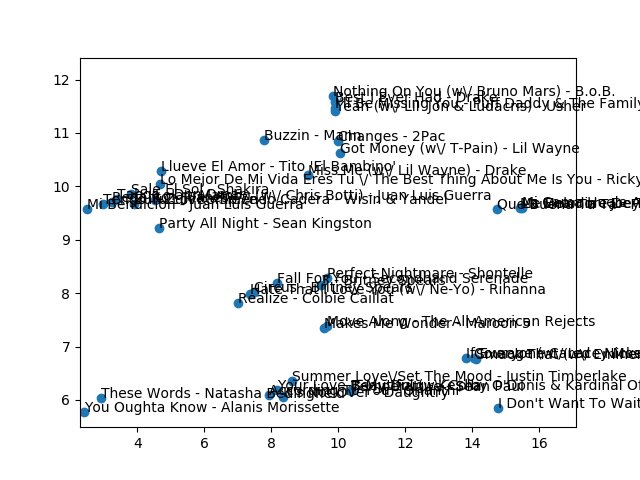

In [2]:
# Part 1

import random
import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import cPickle
import math
import os

from pyspark.mllib.clustering import KMeans
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SparkSession
from sklearn.manifold import TSNE
from IPython.display import Image
from IPython.display import display as Display

################################################################################
# Part 1 functions

def labeledPointMap(row):
    return LabeledPoint(row[0], row[1:])
    
def kMeansPredictMap(row, model):
    predicted_cluster = model.predict(row[1])
    actual_label_list = []
    actual_label_list.append(row[0])
    return (predicted_cluster, actual_label_list)

def predictionLabelReduce(x, y): # To be called with reduceByKey
    if len(x) > len(y):
        for item in y:
            x.append(item)
        return x
    else:
        for item in x:
            y.append(item)
        return y
    
def getMostCommonTags(song_label_list, song_to_tag_dict, num_tags_to_show=5):
    results_dict = {}
    for song in song_label_list:
        try:
            for tag in song_to_tag_dict[song]:

                if tag not in results_dict:
                    results_dict[tag] = 0
                results_dict[tag] += 1
        except KeyError:
            print "Could not get tags for Song ID " + str(song)
    results = results_dict.items()
    results.sort(key=lambda x: x[1], reverse=True)
    return results[:num_tags_to_show]

################################################################################
SONG_ID_TAG_ID_MAP_PATH = '/project/cmsc25025/playlist/song-to-tags.txt'
TAG_ID_TAG_MAP_PATH = '/project/cmsc25025/playlist/tag_hash.txt'
SONG_ID_TO_NAME_AND_ARTIST_PATH = '/project/cmsc25025/playlist/song_hash.txt'
NUM_CHUNKS = 100

# Setup
os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

# Parts a) - c)
song_to_tag_dict = {}
with open(SONG_ID_TAG_ID_MAP_PATH, 'r') as f:
    for line in f:
        elements = line.strip().split('\t')
        song_to_tag_dict[elements[0]] = [x.strip().lower() for x in elements[1].split(',')]
        
tag_id_to_tag_dict = {}
with open(TAG_ID_TAG_MAP_PATH, 'r') as f:
    for line in f:
        elements = line.strip().split(',')
        tag = elements[1].strip().lower()
        if len(tag) > 1 or tag[0] != '#':
            tag_id_to_tag_dict[elements[0]] = tag
            
song_id_to_name_and_artist_dict = {}
with open(SONG_ID_TO_NAME_AND_ARTIST_PATH) as f:
    for line in f:
        elements = line.strip().split('\t')
        key = elements[0]
        song_name = elements[1].strip()
        artist = elements[2].strip()
        song_id_to_name_and_artist_dict[key] = (song_name, artist)
        
song_glove_vectors_file = './GloVe/song-vectors.txt'
song_glove_words = []
song_glove_vectors = {}
delabeled_vector_list = []

with open(song_glove_vectors_file, 'r') as f:
    for line in f:
        song_glove_vals = line.rstrip().split(' ')
        song_glove_vectors[song_glove_vals[0]] = [float(x) for x in song_glove_vals[1:]]
        song_glove_words.append(line[0])
        delabeled_vector_list.append([float(x) for x in song_glove_vals[1:]])
    
song_glove_vocab = {w: indx for indx, w in enumerate(song_glove_words)}
song_glove_indx_vocab = {indx: w for indx, w in enumerate(song_glove_words)}

# d) 
delabeled_vectors_rdd = spark.sparkContext.parallelize(delabeled_vector_list, NUM_CHUNKS)
num_k = 5
model = KMeans.train(delabeled_vectors_rdd, num_k, maxIterations=50, runs=10, initializationMode="random")

labeled_vectors_rdd = spark.sparkContext.parallelize(song_glove_vectors.items(), NUM_CHUNKS)
prediction_results = labeled_vectors_rdd.map(lambda row: kMeansPredictMap(row, model))\
                                        .reduceByKey(predictionLabelReduce).collect()

for cluster, song_id_list in prediction_results:
    most_common_tag_ids = getMostCommonTags(song_id_list, song_to_tag_dict)
    most_common_tags = []
    for tag_id_pair in most_common_tag_ids:
        tag_id = tag_id_pair[0]
        if tag_id == '#':
            most_common_tags.append(tag_id)
        else:
            most_common_tags.append(tag_id_to_tag_dict[tag_id])
    print "Cluster ID " + str(cluster)
    print "Most common tags: "
    for mct in most_common_tags:
        print "\t" + str(mct)
    
# e)

'''Code below used to generate plot'''

# %matplotlib notebook

# tsne = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
# words = []
# vectors = []

# for key in song_glove_vectors:
#     try:
#         words.append(song_id_to_name_and_artist_dict[key][0].decode('utf8') + " - " + \
#                      song_id_to_name_and_artist_dict[key][1].decode('utf8'))
#         vectors.append(np.array(song_glove_vectors[key]))
#     except KeyError:
#         print "Unable to plot key " + str(key)

# words = np.array(words)
# vectors = np.array(vectors)

# Y = tsne.fit_transform(vectors[:1000,:])
# plt.scatter(Y[:, 0], Y[:, 1])
# for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
#plt.show()

Display(Image(filename='p3_song_plot.png'))

spark.stop()

In [ ]:
# Comments:
# D)
# The clusters we obtain are actually fairly interesting.
# Cluster 0 seems to suggest that country music is associated with male singers and enthusiam on this site
# Clusters 1,2,3 seems to suggest the same thing about rock and pop, and that rock and pop comprise
# the majority of the music on this site. It would be intersting to see what seperates these clusters, as
# it does not appear that the top 5 tags provide much distinction between these clusters
# Cluster 4 links hip-hop with r and b and dance music, which is what a reasonable listener would expect
# As a whole, it would appear that the music on this site is fairly mainstream
# E)
# This area of the plot is interesting. At the top, we see B.O.B linked with Usher and Ludacris. Below, we see hip-hop songs
# which is to be expected. However, below that, we see several spanish songs, which is extremely interesting given that those
# lyrics would likely feature heavy concentrations of spanish words. We also see Sean Kingston, which is to be expected.
# Drawing a horizontal line at y = 9, below that line, we see see a cluster of female singers containing Shontelle, Rihanna,
# and Colbie Callait, which is unsuprising. Below that, we see a cluster a pop songs (J.T, All American Rejects, Alanis
# Morissette) is expected. What is unexpected, however, is the proximity of these clusters to each other, given
# the different lyrical content and general musical attributes (BPM, bass lines, beats, etc.) of these songs
# If there were a way to encode that information, perhaps we would get more interesting and algorithmically applicable
# results from a music recommendation standpoint

Spark Session web UI: http://10.50.221.201:4040
Most similar artists to The Beatles:
	creedence clearwater revival : 0.921033517138
	stealers wheel : 0.907686168379
	the kinks : 0.851063192247
	norman greenbaum : 0.84453777051
	manfred mann's earth band : 0.831964293511
Most similar artists to The Red Hot Chili Peppers:
	pearl jam : 0.947268903198
	nirvana : 0.946631388489
	stone temple pilots : 0.946570228919
	sublime : 0.928647537037
	the beastie boys : 0.910325652049
Most similar artists to Usher:
	b.o.b : 0.930561275747
	far east movement : 0.916574404457
	b.o.b. : 0.90680389955
	rihanna : 0.899553165237
	the game : 0.891015530227


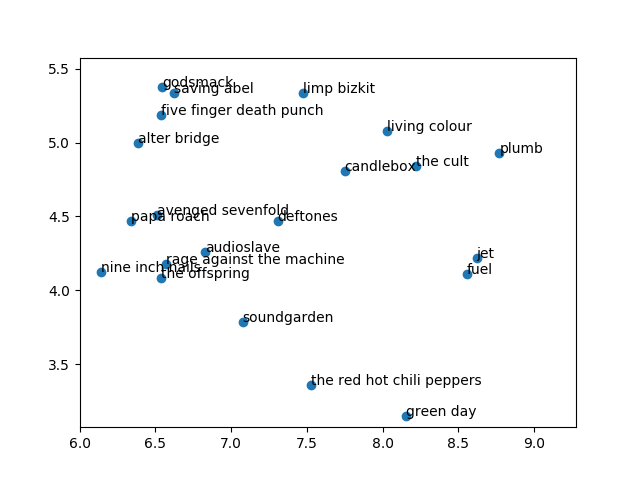

In [1]:
import random
import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import cPickle
import math
import os

from pyspark.mllib.clustering import KMeans
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SparkSession
from sklearn.manifold import TSNE
from IPython.display import Image
from IPython.display import display as Display

################################################################
def getSortedSimilarity(static_vector, vocab_list, vectors_dict, cutoff):
    vocabRDD = spark.sparkContext.parallelize(vocab_list)
    similarity_list = vocabRDD.map(lambda word: \
                                   similarityMap(word, vectors_dict, static_vector)).\
                                   collect()
    similarity_list.sort(key=lambda x: x[1], reverse=True)
    return similarity_list[:cutoff]

def similarityMap(word, vectors_dict, static_vector):
    return (word, calcCosineSimilarity(vectors_dict[word], static_vector))

def calcCosineSimilarity(vector1, vector2):
    v1_mag = np.linalg.norm(vector1)
    v2_mag = np.linalg.norm(vector2)

    denominator = float(v1_mag) * float(v2_mag)

    numerator = float(np.dot(vector1, vector2))

    return numerator/denominator

################################################################

ART_ID_TO_TAG_ID_MAP_PATH = '/project/cmsc25025/playlist/artist-playlists.txt'
ART_ID_TO_ART_MAP_PATH = '/project/cmsc25025/playlist/artist_hash.txt'
NUM_CHUNKS = 100

# Setup
os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('Spark Try') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

# Part 2
# a-c) 
artist_id_to_tag_dict = {}
with open(ART_ID_TO_TAG_ID_MAP_PATH, 'r') as f:
    for line in f:
        elements = line.strip().split()
        artist_id_to_tag_dict[elements[0]] = [x for x in elements[1:]]
        
artist_id_to_artist_dict = {}
artist_to_artist_id_dict = {}
with open(ART_ID_TO_ART_MAP_PATH, 'r') as f:
    for line in f:
        elements = line.strip().split('\t')
        artist = elements[1].strip().lower()
        if len(artist) > 1 or artist[0] != '#':
            artist_id_to_artist_dict[elements[0]] = artist
            artist_to_artist_id_dict[artist] = elements[0]
        
art_glove_vectors_file = './GloVe/artist-vectors.txt'
art_glove_words = []
art_glove_vectors = {}
delabeled_vector_list = []

with open(art_glove_vectors_file, 'r') as f:
    for line in f:
        art_glove_vals = line.rstrip().split()
        art_glove_vectors[art_glove_vals[0]] = [float(x) for x in art_glove_vals[1:]]
        art_glove_words.append(art_glove_vals[0])
        delabeled_vector_list.append([float(x) for x in art_glove_vals[1:]])

# d)

ARTIST_LIST = ['The Beatles', 'The Red Hot Chili Peppers', 'Usher']
for artist in ARTIST_LIST:
    artist_id = artist_to_artist_id_dict[artist.strip().lower()]
    results = getSortedSimilarity(art_glove_vectors[artist_id],
                                  art_glove_words, art_glove_vectors, 5 + 1)
    print "Most similar artists to " + artist + ":"
    for sim_art_id, score in results[1:]:
        print "\t" + str(artist_id_to_artist_dict[sim_art_id]) + " : " + str(score)

# e)

''' Code below used to generate plot '''
# %matplotlib notebook

# tsne = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
# words = []
# vectors = []

# for key in art_glove_vectors:
#     try:
#         words.append(artist_id_to_artist_dict[key].decode('utf8'))
#         vectors.append(np.array(art_glove_vectors[key]))
#     except KeyError:
#         print "Unable to plot key " + str(key)

# words = np.array(words)
# vectors = np.array(vectors)

# Y = tsne.fit_transform(vectors[:1000,:])
# plt.scatter(Y[:, 0], Y[:, 1])
# for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
# #plt.show()

Display(Image(filename='p3_artist_plot.png'))

spark.stop()

In [ ]:
# Comments:
# D)
# As a whole, these results make a lot of sense. The music produced by the artists
# listed in the similarity rankings are, generally, sound similar to the artists to which
# they are being compared. These results indicate that our technique has some measure
# of predictive efficacy
# E)
# This area of the plot has some interesting things going on in it.
# We draw a diagonal from the bottom left to the top right. In the left triangle, we have
# a series of rap/metal artists with aggresive lyrics and similar sounds. This result is unsuprising.
# However, below, we have artists such as green day and the red hot chili peppers which are similar to each other,
# but who most listeners would not consider similar to the artists in the top left triangle in terms of both
# overall sound and lyrical content. It would be interesting to link these artist groups together in a spotify/radio
# playlist, and see what viewer reactions would be.